In [1]:
from run import Prepro
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

In [27]:
train_test_split = 0.2 #how much train test data
predict_at = 8 #steps_out
window_size = 8 #how many timesteps from the past to take ie steps_in

#vision_data = np.load('data/vision_data_30_16_120_3years_test2.npy', allow_pickle = True)
vision_data = np.load('data/vision_data_50_20_60_3years_v2.npy', allow_pickle = True)
#y = np.load('data/y_30_16_120_3years_test2.npy', allow_pickle = True)
y = np.load('data/y_50_20_60_3years_v2.npy', allow_pickle = True)
train_tensors, test_tensors = Prepro.process(vision_data, y, train_test_split, predict_at = 8, window_size =  8)
x_viz_train, x_stat_train, tgt_intensity_cat_train, tgt_intensity_cat_baseline_train, tgt_displacement_train, tgt_intensity_train = train_tensors
x_viz_test, x_stat_test, tgt_intensity_cat_test, tgt_intensity_cat_baseline_test, tgt_displacement_test, tgt_intensity_test = test_tensors

New dataset and corresponding sizes (null elements included):
X_vision torch.Size([3735, 8, 9, 25, 25])
X_stat torch.Size([3735, 8, 10])
target_displacement torch.Size([3735, 8, 2])
target_intensity torch.Size([3735])
target_intensity_cat torch.Size([3735])
target_intensity_cat_baseline torch.Size([3735])
Keeping 3143 samples out of the initial 3735.
Reshaping the displacement target...


In [4]:
x_stat_train[0,1,:]
#'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'STORM_SPEED', 'STORM_DIR', 


#'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND',
#'STORM_SPEED', 'STORM_DIR', 'storm_category', 'basin_EP', 'basin_NI',
#'basin_SI', 'basin_SP', 'basin_WP', 'nature_DS', 'nature_ET',
#'nature_MX', 'nature_NR', 'nature_SS', 'nature_TS'
#'STORM CATEGORY', 
#'STORM_DISPLACEMENT_X', 'STORM_DISPLACEMENT_Y'

tensor([ 3.5125e+00, -1.7131e+02,  3.0000e+01,  1.0040e+03,  1.9080e+03,
         3.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.1250e-01,
        -7.0000e-03])

In [5]:
tgt_displacement_train.shape

torch.Size([1718, 2])

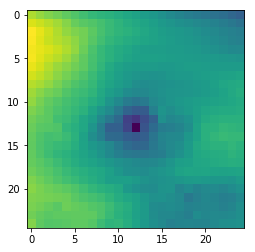

In [6]:
plt.imshow(x_viz_train[20,7,7])

In [29]:
x_viz_train.shape
#samples * timesteps * number of maps * size of map * size of map

torch.Size([628, 8, 9, 25, 25])

In [30]:
x_stat_train.shape
#samples * number of past timesteps * number of features

torch.Size([628, 8, 10])

In [26]:
y.shape
#number of storms * number of timesteps * number of features

(192, 120, 22)

In [28]:
X_train = x_stat_train.reshape(-1, 8*21)
X_test = x_stat_test.reshape(-1, 8*21)

RuntimeError: shape '[-1, 168]' is invalid for input of size 50240

In [11]:
X_train_vision = x_viz_train.reshape(x_viz_train.shape[0], -1)
X_test_vision = x_viz_test.reshape(x_viz_test.shape[0], -1)

In [20]:
X_train_tab_vision = np.concatenate((X_train, X_train_vision), axis = 1)
X_test_tab_vision = np.concatenate((X_test, X_test_vision), axis = 1)

In [12]:
xgb = XGBClassifier(max_depth=5, n_estimators=80)
xgb.fit(X_train, tgt_intensity_cat_train)
yhat = xgb.predict(X_test)
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

XGB score 0.8837649112598196
Baseline score 0.8910386965376782


In [24]:
xgb = XGBClassifier(max_depth=6, n_estimators=200)
xgb.fit(X_train_tab_vision, tgt_intensity_cat_train)
yhat = xgb.predict(X_test_tab_vision)
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

KeyboardInterrupt: 

In [13]:
xgb = XGBClassifier(max_depth=4, n_estimators=80)
xgb.fit(X_train_vision, tgt_intensity_cat_train)
yhat = xgb.predict(X_test_vision)
print("XGB score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

KeyboardInterrupt: 

In [55]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, tgt_intensity_cat_train)
yhat = rf.predict(X_test)
print("RF score", accuracy_score(tgt_intensity_cat_test, yhat))
print("Baseline score", accuracy_score(tgt_intensity_cat_test, tgt_intensity_cat_baseline_test))

RF score 0.8814372999709048
Baseline score 0.8910386965376782


In [68]:
xgb_x = XGBRegressor(max_depth=3, n_estimators=80)
xgb_y = XGBRegressor(max_depth=3, n_estimators=80)
xgb_x.fit(X_train, tgt_displacement_train[:,0])
xgb_y.fit(X_train, tgt_displacement_train[:,1])

yhat_x = xgb_x.predict(X_test)
yhat_y = xgb_y.predict(X_test)
print("XGB x score", mean_absolute_error(tgt_displacement_test[:,0], yhat_x))
print("XGB y score", mean_absolute_error(tgt_displacement_test[:,1], yhat_y))
#be careful for interpretation because the displacement is in degree + standardized + I did not code any baseline

[22:10:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:10:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB x score 0.34135345
XGB y score 0.33949062


In [69]:
tgt_displacement_train.max()

tensor(4.7578)

In [74]:
tgt_displacement_train[:,0].std()

tensor(1.0000)